<a href="https://colab.research.google.com/github/fridriscvski/blender-segmentation/blob/main/blender_ds_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U segmentation-models-pytorch
!pip install  --force-reinstall albumentations 1.4.0

!pip uninstall pretrainedmodels -y
!pip uninstall efficientnet-pytorch -y
!pip uninstall timm -y

!pip install timm==0.9.12
!pip install pretrainedmodels>=0.7.4
!pip install efficientnet-pytorch>=0.7.1
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np
import os
import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
import albumentations as albu
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
from albumentations.pytorch import ToTensorV2
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
colors = [
    (0,0,0),                        # background
    (155/255, 210/255, 10/255),     # corns
    (255/255, 111/255, 97/255),     # Amaranthus hybridos
    (255/255, 215/255, 0/255),      # Cyclospermum leptophyllum
    (64/255, 224/255, 208/255),     # Tridax procumbens
    (147/255, 112/255, 219/255),    # Sonchus oleraceus
    (0/255, 255/255, 0/255),        # Bidens-pilosa
    (255/255, 69/255, 0/255),       # Lelidium virginum
    (135/255, 206/255, 235/255),    # Ipomoeae purpurea
    (138/255, 43/255, 226/255),     # Leonurus sibiricus
    (255/255, 20/255, 147/255),     # Sorghum arundinaceum
    (50/255, 205/255, 50/255),      # Rhynchelytrumrepens
    (186/255, 85/255, 211/255),     # Digitaria insularis
    (255/255, 99/255, 71/255),      # Choris barbata
    (0/255, 206/255, 209/255),      # Cenchus echinatus
    (139/255, 69/255, 19/255)       # Physalis angulata
]

# Define positions
positions = np.linspace(0, 1, len(colors))

# Create colormap
cmap = LinearSegmentedColormap.from_list('CustomCmap', list(zip(positions, colors)))

def convert_visualizable_mask(mask):
    combined_mask = np.zeros((mask.shape[1], mask.shape[2]))
    for channel in range(mask.shape[0]):
        combined_mask[mask[channel, :, :] == 1] = channel

    return combined_mask

In [ ]:
import os

DATASET_PATH = 'drive/My Drive/TCC/cropped_corn_weeds'
TRAIN_DATASET_PATH = 'drive/My Drive/TCC/cropped_blender_digital_twin'
TEST_DATASET_PATH = os.path.join(DATASET_PATH, 'test')
VAL_DATASET_PATH = os.path.join(DATASET_PATH, 'validation')

In [ ]:
print(f"Train set: {len(os.listdir(os.path.join(TRAIN_DATASET_PATH, 'images')))} samples")
print(f"Train set: {len(os.listdir(os.path.join(TRAIN_DATASET_PATH, 'annotations')))} samples")

print(f"Test set: {len(os.listdir(os.path.join(TEST_DATASET_PATH, 'images')))} samples")
print(f"Validation set: {len(os.listdir(os.path.join(VAL_DATASET_PATH, 'images')))} samples")

Train set: 18000 samples
Train set: 18000 samples
Test set: 3846 samples
Validation set: 3754 samples


In [ ]:
class CornWeedsDataset(Dataset):
    CLASSES = [
        "background", "corns", "amaranthus hybridos", "cyclospermum leptophyllum", "tridax procumbens",
        "sonchus oleraceus", "bidens-pilosa", "lelidium virginum", "ipomoeae purpurea",
        "leonurus sibiricus", "sorghum arundinaceum", "rhynchelytrumrepens", "digitaria insularis",
        "choris barbata", "cenchus echinatus", "physalis angulata"
    ]

    def __init__(
        self,
        images_dir,
        annotations_dir,
        classes=None,
        preprocessing=None,
        transform=None
  ):
        self.ids = os.listdir(images_dir)
        self.images = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.annotations = [os.path.join(annotations_dir, image_id) for image_id in self.ids]
        self.preprocessing = preprocessing
        self.transform = transform
        self.images.sort()
        self.annotations.sort()

        if classes:
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        else:
            self.class_values = np.arange(0, len(CornWeedsDataset.CLASSES))

    def __getitem__(self, i):
        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.annotations[i], cv2.IMREAD_GRAYSCALE)

        # mask = np.zeros((simple_mask.shape[0], simple_mask.shape[1], len(self.class_values)))
        # for class_value in self.class_values:
        #     mask[:, :, class_value] = (simple_mask == class_value).astype(float)

        if self.transform is not None:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.images)

In [ ]:
test_transform = albu.Compose([
    albu.PadIfNeeded(min_height=256, min_width=256, border_mode=4),
    albu.Resize(256, 256),
    ToTensorV2(),
])

train_transform = albu.Compose([
    albu.PadIfNeeded(min_height=256, min_width=256, border_mode=4),
    albu.Resize(256, 256),
    albu.RandomBrightnessContrast(),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.MedianBlur(blur_limit=3, p=0.1, always_apply=False),
    ToTensorV2(),
])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
ENCODER = 'resnet152'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = CornWeedsDataset(
    os.path.join(TRAIN_DATASET_PATH, 'images'),
    os.path.join(TRAIN_DATASET_PATH, 'annotations'),
    classes=None,
    preprocessing=get_preprocessing(preprocessing_fn),
    transform=train_transform
)

val_dataset = CornWeedsDataset(
    os.path.join(VAL_DATASET_PATH, 'images'),
    os.path.join(VAL_DATASET_PATH, 'annotations'),
    classes=None,
    preprocessing=get_preprocessing(preprocessing_fn),
    transform=test_transform
)

test_dataset = CornWeedsDataset(
    os.path.join(TEST_DATASET_PATH, 'images'),
    os.path.join(TEST_DATASET_PATH, 'annotations'),
    classes=None,
    preprocessing=get_preprocessing(preprocessing_fn),
    transform=test_transform
)

n_workers = os.cpu_count()
batch_size = 8

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, num_workers=n_workers)

val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                              shuffle=False, num_workers=n_workers)

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                               shuffle=False, num_workers=n_workers)

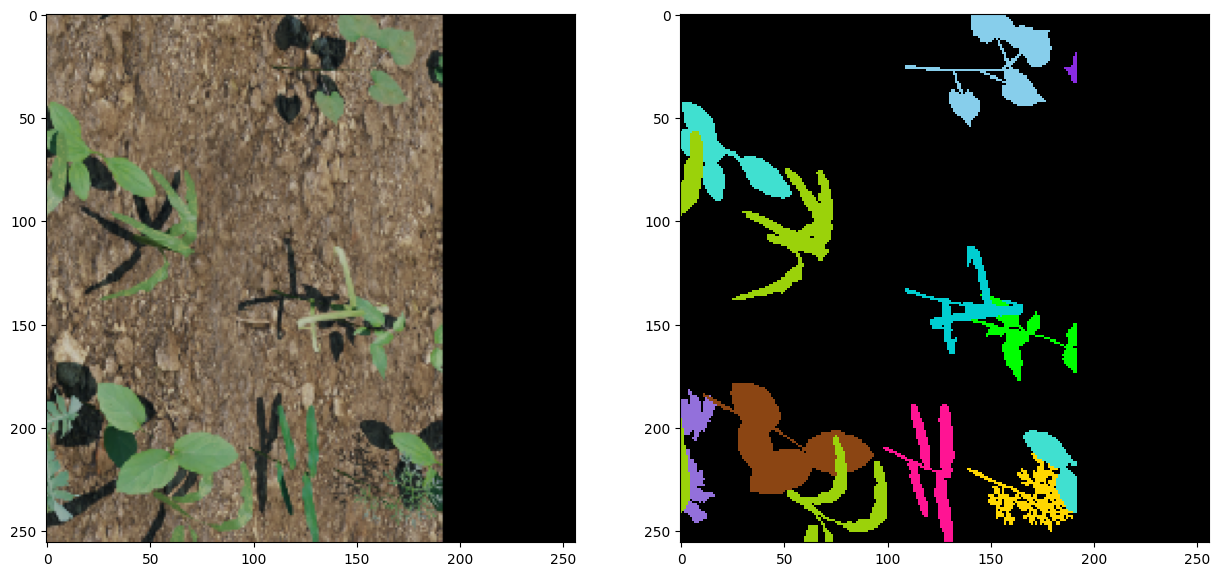

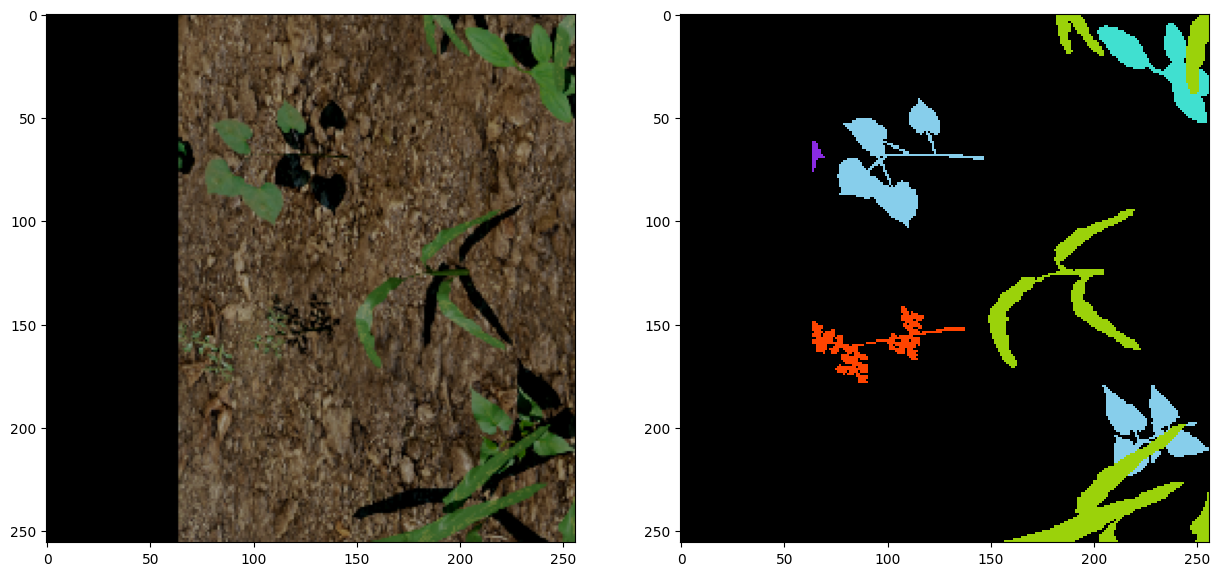

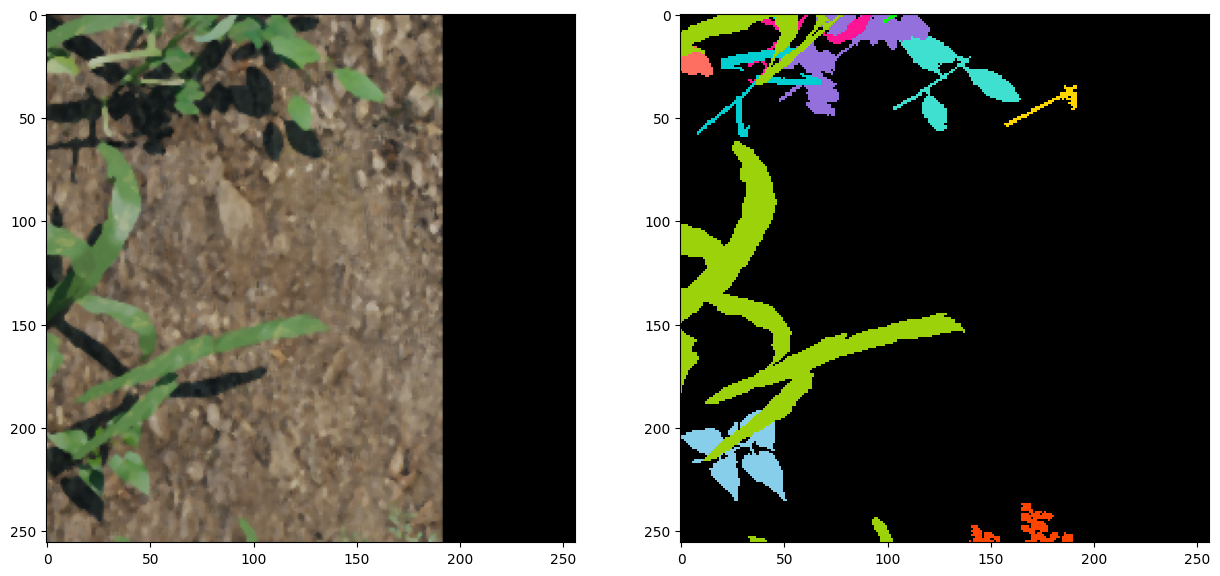

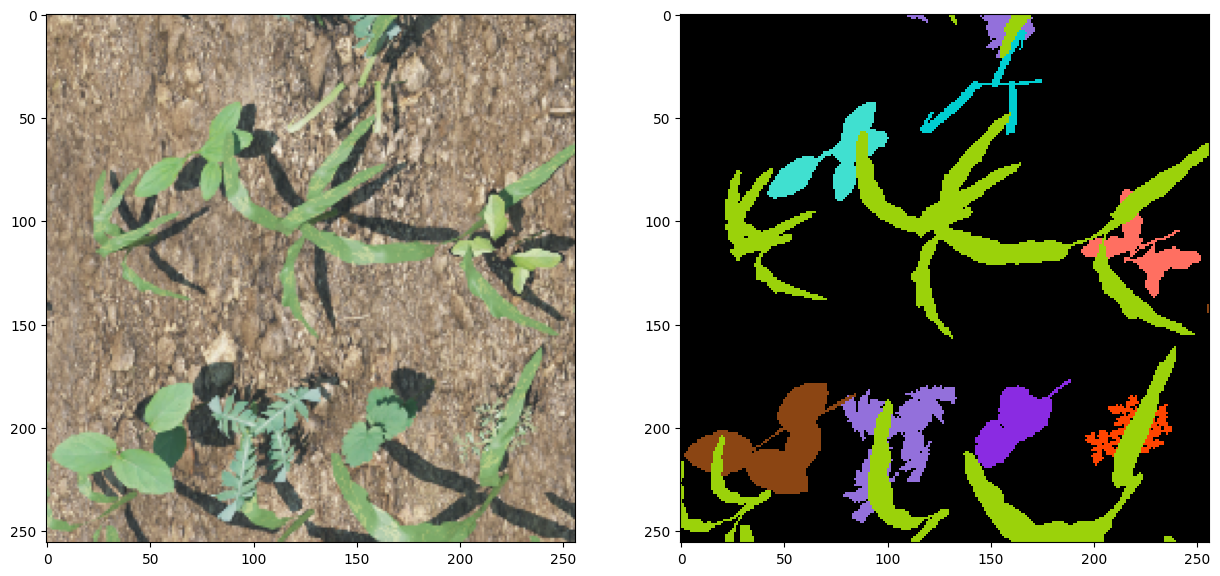

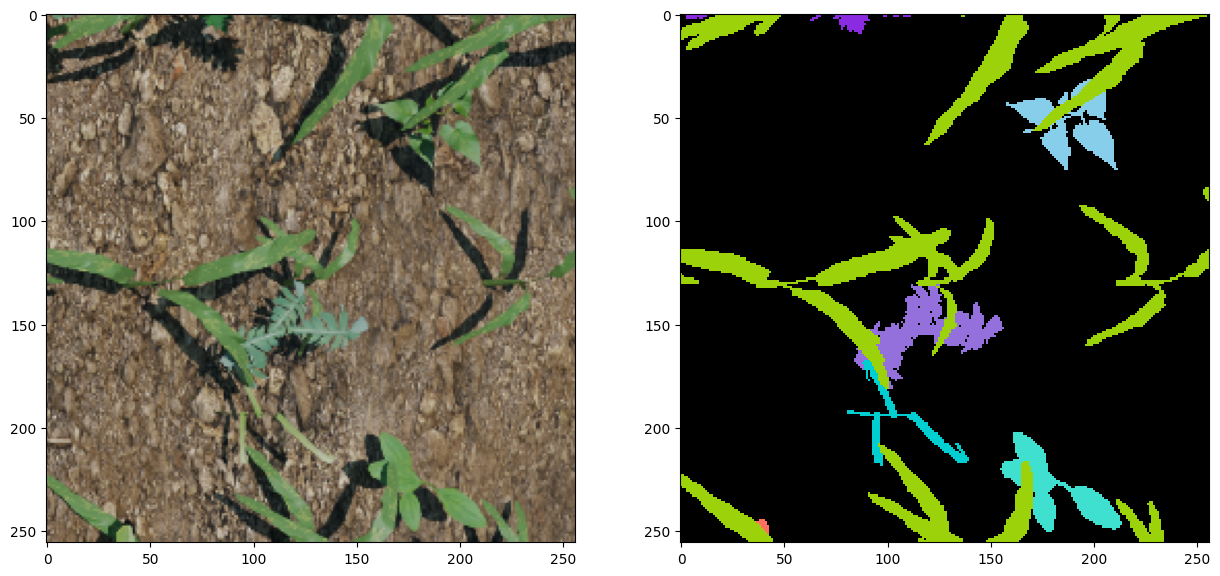

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
for i in range (5):
    img, mask = train_dataset[i]
    #print(f'image: {img.shape} - mask: {mask.shape}')

    _, axis = plt.subplots(1,2, figsize=(15,20))
    axis[0].imshow(img.permute(1,2,0))
    axis[1].imshow(mask, cmap=cmap, vmin=0, vmax=len(colors)-1, interpolation='nearest')

In [ ]:
class AvageraMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]


In [ ]:
from tqdm import tqdm as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ACTIVATION = None
MODE: str = 'multiclass'
LEARNING_RATE = 1e-4

criterion = smp.losses.FocalLoss(mode=MODE)

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels = 3,
    classes=len(CornWeedsDataset.CLASSES),
    activation=ACTIVATION
)

model.to(DEVICE)
num_classes = 16
iou_fn = MulticlassJaccardIndex(num_classes=num_classes, average=None).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss_meter = AvageraMeter()
val_loss_meter = AvageraMeter()
acc_meter = AvageraMeter()
iou_meter = AvageraMeter()
best_miou = 0

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:02<00:00, 119MB/s]


In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

for epoch in range(35):
    train_loss_meter.reset()
    val_loss_meter.reset()
    acc_meter.reset()

    for i, (inputs, labels) in enumerate(tqdm(train_data_loader)):
        optimizer.zero_grad()

        n = inputs.shape[1]
        inputs = inputs.to(DEVICE).float()
        labels = labels.to(DEVICE).long()

        outputs = model(inputs)
        labels = labels.squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            active_output = outputs.sigmoid().round().long()
            active_output = active_output.argmax(dim=1)
            train_loss_meter.update(loss.item(), n)
            acc_meter.update(accuracy_function(active_output, labels), n)
            iou_meter.update(iou_fn(active_output, labels.long()), n)

    print(f'epoch: {epoch}; loss: {train_loss_meter.avg}; accuracy: {acc_meter.avg}; miou: {iou_meter.avg.mean()}; iou: {iou_meter.avg}')

    if iou_meter.avg.mean() > best_miou:
        best_miou = iou_meter.avg.mean()
        print("saving model")
        torch.save(model.state_dict(), f'drive/My Drive/TCC/trained models/unet_fl_blender_model.pth')


100%|██████████| 2250/2250 [22:40<00:00,  1.65it/s]


epoch: 0; loss: 0.2925562910338243; accuracy: 0.8940861821174622; miou: 0.10716528445482254; iou: tensor([8.9672e-01, 5.9423e-01, 3.3935e-03, 4.4356e-05, 6.2309e-03, 2.6719e-02,
        1.2630e-04, 1.0619e-04, 6.7419e-05, 3.0154e-02, 1.8012e-05, 8.5655e-06,
        1.1335e-04, 2.5102e-05, 1.1898e-05, 1.5668e-01], device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:49<00:00,  9.82it/s]


epoch: 1; loss: 0.06525852920363347; accuracy: 0.9516937136650085; miou: 0.19305655360221863; iou: tensor([9.2453e-01, 6.8449e-01, 2.2731e-01, 6.0203e-03, 1.3443e-01, 2.7273e-01,
        1.5658e-02, 6.9603e-02, 1.1613e-01, 2.4370e-01, 6.0999e-04, 4.2827e-06,
        5.6677e-05, 1.9911e-05, 4.2189e-02, 3.5141e-01], device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:47<00:00,  9.91it/s]


epoch: 2; loss: 0.04866380415194564; accuracy: 0.9655221104621887; miou: 0.28161218762397766; iou: tensor([9.3862e-01, 7.2323e-01, 3.5755e-01, 1.0455e-01, 2.8492e-01, 4.0706e-01,
        1.4590e-01, 1.9553e-01, 2.6458e-01, 3.7125e-01, 8.2867e-02, 9.1498e-05,
        2.4424e-02, 1.8182e-04, 1.4408e-01, 4.6094e-01], device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:47<00:00,  9.90it/s]


epoch: 3; loss: 0.04382944778766897; accuracy: 0.970055878162384; miou: 0.3450218737125397; iou: tensor([0.9468, 0.7453, 0.4283, 0.1789, 0.3693, 0.4793, 0.2524, 0.2763, 0.3468,
        0.4448, 0.1852, 0.0062, 0.1182, 0.0101, 0.2110, 0.5214],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:45<00:00,  9.97it/s]


epoch: 4; loss: 0.03946355446096923; accuracy: 0.9729926586151123; miou: 0.39236584305763245; iou: tensor([0.9523, 0.7608, 0.4759, 0.2316, 0.4275, 0.5279, 0.3258, 0.3316, 0.4042,
        0.4970, 0.2589, 0.0284, 0.1902, 0.0408, 0.2611, 0.5637],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:48<00:00,  9.86it/s]


epoch: 5; loss: 0.036742774297793705; accuracy: 0.9748169779777527; miou: 0.4291088879108429; iou: tensor([0.9563, 0.7726, 0.5107, 0.2703, 0.4708, 0.5624, 0.3812, 0.3736, 0.4463,
        0.5328, 0.3131, 0.0640, 0.2437, 0.0735, 0.3004, 0.5941],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:50<00:00,  9.78it/s]


epoch: 6; loss: 0.03490932760056522; accuracy: 0.9759584665298462; miou: 0.4578099548816681; iou: tensor([0.9592, 0.7819, 0.5368, 0.3010, 0.5029, 0.5890, 0.4219, 0.4052, 0.4781,
        0.5597, 0.3545, 0.0978, 0.2842, 0.1027, 0.3320, 0.6180],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:51<00:00,  9.74it/s]


epoch: 7; loss: 0.03330804269346926; accuracy: 0.9769644141197205; miou: 0.48127004504203796; iou: tensor([0.9616, 0.7895, 0.5582, 0.3268, 0.5291, 0.6107, 0.4540, 0.4310, 0.5040,
        0.5812, 0.3874, 0.1272, 0.3181, 0.1276, 0.3575, 0.6365],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:51<00:00,  9.72it/s]


epoch: 8; loss: 0.03244163128485282; accuracy: 0.977509081363678; miou: 0.5003360509872437; iou: tensor([0.9634, 0.7958, 0.5754, 0.3478, 0.5502, 0.6269, 0.4796, 0.4526, 0.5247,
        0.5975, 0.4145, 0.1523, 0.3452, 0.1496, 0.3781, 0.6517],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:50<00:00,  9.74it/s]


epoch: 9; loss: 0.031674116908676095; accuracy: 0.9780417084693909; miou: 0.516452431678772; iou: tensor([0.9650, 0.8011, 0.5896, 0.3652, 0.5674, 0.6408, 0.5011, 0.4703, 0.5416,
        0.6121, 0.4371, 0.1737, 0.3687, 0.1691, 0.3958, 0.6646],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:50<00:00,  9.78it/s]


epoch: 10; loss: 0.03069461470014519; accuracy: 0.9786437153816223; miou: 0.5303380489349365; iou: tensor([0.9663, 0.8058, 0.6016, 0.3800, 0.5835, 0.6521, 0.5192, 0.4848, 0.5571,
        0.6240, 0.4560, 0.1930, 0.3883, 0.1859, 0.4108, 0.6770],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:51<00:00,  9.74it/s]


epoch: 11; loss: 0.029799560692989165; accuracy: 0.9791499972343445; miou: 0.5424550771713257; iou: tensor([0.9675, 0.8099, 0.6123, 0.3934, 0.5972, 0.6621, 0.5340, 0.4979, 0.5699,
        0.6347, 0.4723, 0.2095, 0.4062, 0.2013, 0.4241, 0.6871],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:49<00:00,  9.81it/s]


epoch: 12; loss: 0.029179403345204063; accuracy: 0.9794932007789612; miou: 0.5531557202339172; iou: tensor([0.9685, 0.8135, 0.6214, 0.4050, 0.6096, 0.6710, 0.5479, 0.5093, 0.5810,
        0.6441, 0.4866, 0.2245, 0.4212, 0.2152, 0.4355, 0.6962],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:49<00:00,  9.79it/s]


epoch: 13; loss: 0.028191587701853777; accuracy: 0.9800216555595398; miou: 0.5628596544265747; iou: tensor([0.9693, 0.8169, 0.6300, 0.4157, 0.6202, 0.6789, 0.5594, 0.5198, 0.5912,
        0.6524, 0.4993, 0.2384, 0.4349, 0.2289, 0.4459, 0.7045],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:51<00:00,  9.74it/s]


epoch: 14; loss: 0.027844608416159947; accuracy: 0.9802454710006714; miou: 0.5714375972747803; iou: tensor([0.9701, 0.8198, 0.6374, 0.4252, 0.6297, 0.6858, 0.5700, 0.5289, 0.6000,
        0.6596, 0.5110, 0.2507, 0.4474, 0.2406, 0.4551, 0.7117],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:49<00:00,  9.80it/s]


epoch: 15; loss: 0.027122065500666696; accuracy: 0.9806171655654907; miou: 0.5793904066085815; iou: tensor([0.9708, 0.8226, 0.6441, 0.4338, 0.6384, 0.6920, 0.5795, 0.5372, 0.6084,
        0.6666, 0.5214, 0.2623, 0.4594, 0.2523, 0.4633, 0.7182],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:49<00:00,  9.79it/s]


epoch: 16; loss: 0.0267718830841283; accuracy: 0.9807765483856201; miou: 0.586483359336853; iou: tensor([0.9714, 0.8250, 0.6500, 0.4416, 0.6460, 0.6978, 0.5881, 0.5450, 0.6158,
        0.6727, 0.5305, 0.2729, 0.4696, 0.2623, 0.4710, 0.7238],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:51<00:00,  9.73it/s]


epoch: 17; loss: 0.026385845197157726; accuracy: 0.9809819459915161; miou: 0.5930745005607605; iou: tensor([0.9720, 0.8273, 0.6554, 0.4489, 0.6535, 0.7034, 0.5959, 0.5518, 0.6224,
        0.6782, 0.5391, 0.2831, 0.4791, 0.2718, 0.4780, 0.7292],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:50<00:00,  9.78it/s]


epoch: 18; loss: 0.025946198500692845; accuracy: 0.9812198877334595; miou: 0.599083423614502; iou: tensor([0.9725, 0.8294, 0.6603, 0.4556, 0.6599, 0.7082, 0.6030, 0.5583, 0.6287,
        0.6828, 0.5469, 0.2921, 0.4878, 0.2811, 0.4848, 0.7341],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:50<00:00,  9.77it/s]


epoch: 19; loss: 0.02541839423899849; accuracy: 0.9814390540122986; miou: 0.6046181917190552; iou: tensor([0.9730, 0.8314, 0.6653, 0.4619, 0.6660, 0.7122, 0.6094, 0.5643, 0.6343,
        0.6874, 0.5540, 0.3007, 0.4954, 0.2894, 0.4906, 0.7387],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:47<00:00,  9.91it/s]


epoch: 20; loss: 0.025171285040262673; accuracy: 0.981627881526947; miou: 0.609870433807373; iou: tensor([0.9735, 0.8332, 0.6693, 0.4677, 0.6718, 0.7163, 0.6153, 0.5696, 0.6396,
        0.6916, 0.5609, 0.3089, 0.5030, 0.2979, 0.4964, 0.7430],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:48<00:00,  9.83it/s]


epoch: 21; loss: 0.02474774199600021; accuracy: 0.981802225112915; miou: 0.6146552562713623; iou: tensor([0.9739, 0.8349, 0.6732, 0.4730, 0.6770, 0.7199, 0.6208, 0.5749, 0.6441,
        0.6954, 0.5672, 0.3162, 0.5100, 0.3056, 0.5016, 0.7470],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:49<00:00,  9.80it/s]


epoch: 22; loss: 0.024270203181852898; accuracy: 0.9820345044136047; miou: 0.6192432045936584; iou: tensor([0.9742, 0.8365, 0.6769, 0.4780, 0.6819, 0.7234, 0.6262, 0.5799, 0.6484,
        0.6991, 0.5727, 0.3234, 0.5163, 0.3133, 0.5067, 0.7509],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:51<00:00,  9.71it/s]


epoch: 23; loss: 0.024061479358209504; accuracy: 0.9821605682373047; miou: 0.6235225796699524; iou: tensor([0.9746, 0.8380, 0.6803, 0.4826, 0.6865, 0.7267, 0.6310, 0.5843, 0.6527,
        0.7025, 0.5782, 0.3303, 0.5225, 0.3206, 0.5116, 0.7541],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:50<00:00,  9.74it/s]


epoch: 24; loss: 0.023750338303960034; accuracy: 0.9823455214500427; miou: 0.6276072263717651; iou: tensor([0.9749, 0.8394, 0.6835, 0.4871, 0.6909, 0.7297, 0.6355, 0.5885, 0.6569,
        0.7061, 0.5831, 0.3369, 0.5281, 0.3274, 0.5162, 0.7574],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:47<00:00,  9.91it/s]


epoch: 25; loss: 0.023711127558930054; accuracy: 0.9823206067085266; miou: 0.6313530206680298; iou: tensor([0.9752, 0.8407, 0.6868, 0.4912, 0.6950, 0.7325, 0.6398, 0.5923, 0.6605,
        0.7088, 0.5880, 0.3431, 0.5334, 0.3337, 0.5203, 0.7603],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:49<00:00,  9.82it/s]


epoch: 26; loss: 0.023253752854963144; accuracy: 0.9825925230979919; miou: 0.6350032091140747; iou: tensor([0.9755, 0.8420, 0.6899, 0.4953, 0.6990, 0.7354, 0.6439, 0.5958, 0.6642,
        0.7117, 0.5924, 0.3491, 0.5385, 0.3396, 0.5242, 0.7634],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:48<00:00,  9.84it/s]


epoch: 27; loss: 0.022879606083035468; accuracy: 0.9827803373336792; miou: 0.6384616494178772; iou: tensor([0.9758, 0.8432, 0.6928, 0.4990, 0.7027, 0.7380, 0.6477, 0.5996, 0.6675,
        0.7144, 0.5968, 0.3549, 0.5437, 0.3454, 0.5279, 0.7659],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:47<00:00,  9.89it/s]


epoch: 28; loss: 0.022893116137633722; accuracy: 0.9827925562858582; miou: 0.6416851878166199; iou: tensor([0.9760, 0.8444, 0.6952, 0.5026, 0.7062, 0.7404, 0.6514, 0.6029, 0.6707,
        0.7169, 0.6008, 0.3603, 0.5478, 0.3510, 0.5315, 0.7687],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:51<00:00,  9.72it/s]


epoch: 29; loss: 0.022573739949199888; accuracy: 0.9829478859901428; miou: 0.6448142528533936; iou: tensor([0.9763, 0.8455, 0.6977, 0.5060, 0.7094, 0.7428, 0.6548, 0.6061, 0.6739,
        0.7194, 0.6048, 0.3657, 0.5520, 0.3564, 0.5350, 0.7713],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:49<00:00,  9.82it/s]


epoch: 30; loss: 0.02240034323434035; accuracy: 0.9830244779586792; miou: 0.647752046585083; iou: tensor([0.9765, 0.8465, 0.7001, 0.5094, 0.7123, 0.7450, 0.6580, 0.6092, 0.6769,
        0.7217, 0.6083, 0.3705, 0.5561, 0.3614, 0.5382, 0.7737],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:49<00:00,  9.81it/s]


epoch: 31; loss: 0.022197647489607335; accuracy: 0.9831494092941284; miou: 0.6505687236785889; iou: tensor([0.9767, 0.8475, 0.7024, 0.5125, 0.7153, 0.7470, 0.6612, 0.6122, 0.6796,
        0.7240, 0.6116, 0.3752, 0.5600, 0.3663, 0.5416, 0.7758],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:48<00:00,  9.83it/s]


epoch: 32; loss: 0.022155242313113478; accuracy: 0.9831870198249817; miou: 0.6532102823257446; iou: tensor([0.9769, 0.8485, 0.7045, 0.5155, 0.7178, 0.7488, 0.6640, 0.6150, 0.6822,
        0.7259, 0.6150, 0.3798, 0.5638, 0.3711, 0.5444, 0.7781],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:49<00:00,  9.81it/s]


epoch: 33; loss: 0.021908255260023806; accuracy: 0.9833131432533264; miou: 0.6557352542877197; iou: tensor([0.9771, 0.8494, 0.7066, 0.5183, 0.7204, 0.7506, 0.6668, 0.6176, 0.6847,
        0.7278, 0.6180, 0.3841, 0.5673, 0.3756, 0.5471, 0.7803],
       device='cuda:0')
saving model


100%|██████████| 2250/2250 [03:48<00:00,  9.85it/s]


epoch: 34; loss: 0.021681825500809482; accuracy: 0.983433723449707; miou: 0.6582232117652893; iou: tensor([0.9773, 0.8503, 0.7087, 0.5210, 0.7230, 0.7524, 0.6695, 0.6202, 0.6870,
        0.7298, 0.6210, 0.3885, 0.5707, 0.3799, 0.5500, 0.7823],
       device='cuda:0')
saving model
